## Exercise 1

In [1]:
import math
import numpy as np

alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02
A = alpha*beta
K_ss = A**(1/(1-alpha))

F = (alpha*K_ss**(alpha-1))/(K_ss**alpha-K_ss)
G = -alpha*(K_ss**(alpha-1))*(alpha+K_ss**(alpha-1))/(K_ss**alpha-K_ss)
H = (alpha**2)*(K_ss**(2*(alpha-1)))/(K_ss**alpha - K_ss)
L = -alpha*(K_ss**(2*alpha-1))/(K_ss**alpha - K_ss)
M = (alpha**2)*(K_ss*(2*(alpha-1)))/(K_ss**alpha-K_ss)
N = rho

P = (-G + math.sqrt(G**2-4*F*H))/(2*F)
Q = -(L*N+M)/(F*N+F*P+G)

print("F = " + str(F))
print("G = " + str(G))
print("H = " + str(H))
print("L = " + str(L))
print("M = " + str(M))
print("N = " + str(N))
print("P = " + str(P))
print("Q = " + str(Q))

F = 2.763343017362853
G = -9.023563692703393
H = 2.8197377728192374
L = -1.5531326685925513
M = -0.08313964992389651
N = 0.95
P = 2.915451895043732
Q = 0.9400544167539131


In [2]:
# Define z grid and k grid

K_grid = np.linspace(0.5*K_ss, 1.5*K_ss, 25)

def rouwen(rho, mu, step, num):
    '''
    Adapted from Lu Zhang and Karen Kopecky. Python by Ben Tengelsen.
    Construct transition probability matrix for discretizing an AR(1)
    process. This procedure is from Rouwenhorst (1995), which works
    well for very persistent processes.
    INPUTS:
    rho  - persistence (close to one)
    mu   - mean and the middle point of the discrete state space
    step - step size of the even-spaced grid
    num  - number of grid points on the discretized process
    OUTPUT:
    dscSp  - discrete state space (num by 1 vector)
    transP - transition probability matrix over the grid
    '''

    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp
    
mu = 0.0
rho = 0.9
step = sigma/2.4
num = 25
pi, z_grid = rouwen(rho, mu, step, num)


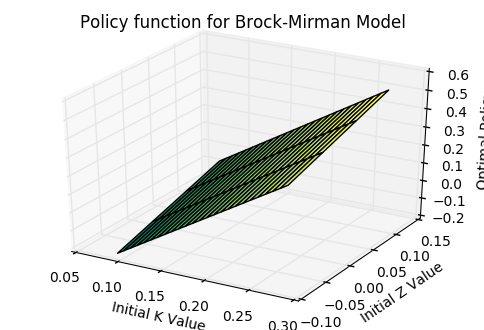

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
import numpy as np

K_grid, z_grid = np.meshgrid(K_grid, z_grid)
H_new = K_ss + P*(K_grid-K_ss) + Q*z_grid

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(K_grid, z_grid, H_new, rstride=8,cstride=1, cmap=cmap1)
ax.set_title('Policy function for Brock-Mirman Model')
ax.set_xlabel('Initial K Value')
ax.set_ylabel('Initial Z Value')
ax.set_zlabel('Optimal Policy')

plt.show()

## Exercise 2

## Exercise 4

In [18]:
def Modeldefs(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # find definintion values
    Y = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha)*(k**alpha)*(np.exp(z))*(ell*np.exp(z))**(-alpha)
    r = alpha*k**(alpha-1)*(ell*np.exp(z))**(1-alpha)
    T = tau*(w*ell + (r-delta)*k)
    c = (1 - tau) * (w * ell + (r - delta) * k) + T + k - kp
    u = (c**(1-gamma)-1)/(1-gamma) + a*((1-ell)**(1-xi)-1)/(1-xi)
    i = delta*k
    return Y, w, r, c, u, T, i

In [19]:
def Modeldyn(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theat0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    ell = Y
    
    # find definitions for now and next period
    Y, w, r, c, u, T, ip = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, cp, up, Tp, ip = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    E1 = beta*(c/cp)**(gamma)*((rp-delta)*(1-tau)+1)-1
    E2 = a*((c**(gamma))/(1-ell)**xi)*(1/(w*(1-tau)))-1
 
    return np.array([E1, E2])

In [20]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.optimize as opt
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

In [21]:
# set parameter values
gamma = 2.5
xi = 1.5
beta = .98
alpha =.40
a = .50
delta = .10
rho = .90
tau = .05

# make parameter list to pass to functions
params = (gamma, xi, beta, alpha, a, delta, rho, tau)

# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 1
nz = 1
logX = 0
Sylv = 1

In [22]:
# take a guess for steady state values of k and ell
guessXY = np.array([2.0, 0.5])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

XYbar:  [ 4.22522903  0.57979145]
check:  [ -3.93751698e-12   9.72510961e-12]


In [23]:
Ybar, wbar, rbar, cbar, ubar, Tbar, ibar = Modeldefs(kbar, kbar, ellbar, 0, params)
print ('Ybar: ', Ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
print ('Tbar: ', Tbar)
print ('ibar: ', ibar)

Ybar:  1.28322610887
wbar:  1.32795276838
rbar:  0.121482277117
cbar:  0.860703206163
ubar:  -0.710872638109
Tbar:  0.0430351603081
ibar:  0.422522902705


## Exercise 5

In [10]:
inc = 1e-08

#Derivatives with respect to delta
delta = delta + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

delta = delta - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to delta")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

delta = delta + inc

#Derivatives with respect to tau

tau = tau + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

tau = tau - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to tau")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

tau = tau + inc

#Derivatives with respect to Zbar

Zbar = Zbar + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

Zbar = Zbar - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to Zbar")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

Zbar = Zbar + inc

#Derivatives with respect to alpha

alpha = alpha + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

alpha = alpha - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to alpha")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

alpha = alpha + inc

#Derivatives with respect to gamma

gamma = gamma + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

gamma = gamma - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to gamma")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

tau = gamma + inc


#Derivatives with respect to xi

xi = xi + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

xi = xi - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to xi")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

tau = xi + inc

#Derivatives with respect to beta

beta = beta + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

beta = beta - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to beta")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

beta = beta + inc

#Derivatives with respect to a

a = a + inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarA, ellbarA) = XYbar
theta0 = np.array([kbarA, kbarA, kbarA, ellbarA, ellbarA, 0., 0.])
YbarA, wbarA, rbarA, cbarA, ubarA, TbarA, ibarA = Modeldefs(kbar, kbar, ellbar, 0, params)

a = a - 2*inc

guessXY = np.array([2.0, 0.5])
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbarB, ellbarB) = XYbar
theta0 = np.array([kbarB, kbarB, kbarB, ellbarB, ellbarB, 0., 0.])
YbarB, wbarB, rbarB, cbarB, ubarB, TbarB, ibarB = Modeldefs(kbar, kbar, ellbar, 0, params)

k_deriv = (kbarA - kbarB)/(2*inc)
c_deriv = (cbarA - cbarB)/(2*inc)
r_deriv = (rbarA - rbarB)/(2*inc)
w_deriv = (wbarA - wbarB)/(2*inc)
ell_deriv = (ellbarA - ellbarB)/(2*inc)
T_deriv = (TbarA - TbarB)/(2*inc)
y_deriv = (YbarA-YbarB)/(2*inc)
i_deriv = (ibarA-ibarB)/(2*inc)

print("Derivatives with respect to a")
print(k_deriv, c_deriv, r_deriv, w_deriv, ell_deriv, T_deriv, y_deriv, i_deriv)
print("")

a = a + inc

Derivatives with respect to delta
-48.349842352 -4.22522905552 0.0 0.0 1.31977517248 -0.211261451388 0.0 4.22522902777

Derivatives with respect to tau
-2.32322641125 0.0 0.0 0.0 -0.138923716975 0.860703206276 0.0 0.0

Derivatives with respect to Zbar
2.83828858194 0.0 0.0 0.0 -0.190317855919 0.0 0.0 0.0

Derivatives with respect to alpha
25.9848958795 2.54869272354 0.544988967149 0.424272406097 -0.76938094784 0.12743463576 2.54869272354 0.0

Derivatives with respect to gamma
0.138699629559 0.0 0.0 0.0 0.0190324922489 0.0 0.0 0.0

Derivatives with respect to xi
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

Derivatives with respect to beta
-36.1881808963 0.0 0.0 0.0 0.358850182902 0.0 0.0 0.0

Derivatives with respect to a
1.02273864933 0.0 0.0 0.0 0.255684820538 0.0 0.0 0.0



/Users/Geoff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/Geoff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/Geoff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars
/Users/Geoff/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/Geoff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
/Users/Geoff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars
